# DETECTING VANDALISM ON WIKIPEDIA

One of the consequences of being editable by anyone is that some people vandalize pages. This can take the form of removing content, adding promotional or inappropriate content, or more subtle shifts that change the meaning of the article. With this many articles and edits per day it is difficult for humans to detect all instances of vandalism and revert (undo) them. As a result, Wikipedia uses bots - computer programs that automatically revert edits that look like vandalism. In this assignment we will attempt to develop a vandalism detector that uses machine learning to distinguish between a valid edit and vandalism.

The data for this problem is based on the revision history of the page Language. Wikipedia provides a history for each page that consists of the state of the page at each revision. Rather than manually considering each revision, a script was run that checked whether edits stayed or were reverted. If a change was eventually reverted then that revision is marked as vandalism. This may result in some misclassifications, but the script performs well enough for our needs.

As a result of this preprocessing, some common processing tasks have already been done, including lower-casing and punctuation removal. The columns in the dataset are:

* Vandal = 1 if this edit was vandalism, 0 if not.
* Minor = 1 if the user marked this edit as a "minor edit", 0 if not.
* Loggedin = 1 if the user made this edit while using a Wikipedia account, 0 if they did not.
* Added = The unique words added.
* Removed = The unique words removed.

Notice the repeated use of unique. The data we have available is not the traditional bag of words - rather it is the set of words that were removed or added. For example, if a word was removed multiple times in a revision it will only appear one time in the "Removed" column.

In [33]:
wiki = read.csv('data/wiki.csv', stringsAsFactors=FALSE)

In [34]:
wiki$Vandal = as.factor(wiki$Vandal)

In [35]:
str(wiki)

'data.frame':	3876 obs. of  7 variables:
 $ X.1     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ X       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Vandal  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Minor   : int  1 1 0 1 1 0 0 0 1 0 ...
 $ Loggedin: int  1 1 1 0 1 1 1 1 1 0 ...
 $ Added   : chr  "  represent psycholinguisticspsycholinguistics orthographyorthography help text all actions through human ethnologue relationsh"| __truncated__ " website external links" " " " afghanistan used iran mostly that farsiis is countries some xmlspacepreservepersian parts tajikestan region" ...
 $ Removed : chr  " " " talklanguagetalk" " regarded as technologytechnologies human first" "  represent psycholinguisticspsycholinguistics orthographyorthography help all actions through ethnologue relationships linguis"| __truncated__ ...


In [36]:
table(wiki$Vandal)


   0    1 
2061 1815 

## Pre-Processing

In [37]:
library(tm)
corpusAdded = Corpus(VectorSource(wiki$Added))

In [38]:
corpusAdded = tm_map(corpusAdded, removeWords, stopwords('english'))

In [39]:
corpusAdded = tm_map(corpusAdded, stemDocument)

In [40]:
dtmAdded = DocumentTermMatrix(corpusAdded)

In [41]:
length(stopwords("english"))

[1] 174

In [42]:
dtmAdded

<<DocumentTermMatrix (documents: 3876, terms: 6675)>>
Non-/sparse entries: 15368/25856932
Sparsity           : 100%
Maximal term length: 784
Weighting          : term frequency (tf)

In [43]:
sparseAdded = removeSparseTerms(dtmAdded, 0.997)

In [44]:
sparseAdded

<<DocumentTermMatrix (documents: 3876, terms: 166)>>
Non-/sparse entries: 2681/640735
Sparsity           : 100%
Maximal term length: 28
Weighting          : term frequency (tf)

In [45]:
wordsAdded = as.data.frame(as.matrix(sparseAdded))

In [46]:
colnames(wordsAdded) = paste("A", colnames(wordsAdded))

### For removed:

In [47]:
corpusRemoved = Corpus(VectorSource(wiki$Removed))
corpusRemoved = tm_map(corpusRemoved, removeWords, stopwords('english'))
corpusRemoved = tm_map(corpusRemoved, stemDocument)
dtmRemoved = DocumentTermMatrix(corpusRemoved)
sparseRemoved = removeSparseTerms(dtmRemoved, 0.997)
wordsRemoved = as.data.frame(as.matrix(sparseRemoved))
colnames(wordsRemoved) = paste("R", colnames(wordsRemoved))

In [50]:
wikiWords = cbind(wordsAdded, wordsRemoved)

In [51]:
wikiWords$Vandal = wiki$Vandal

## Train Test Split:

In [52]:
library(caTools)
set.seed(123)
spl = sample.split(wikiWords$Vandal, 0.7)
train = subset(wikiWords, spl == TRUE)
test = subset(wikiWords, spl == FALSE)

In [54]:
# ACC baseline:
table(test$Vandal)


  0   1 
618 545 

In [56]:
618/(618+545)

[1] 0.5313844

## CART model:

In [57]:
library(rpart)
library(rpart.plot)
wikiCART = rpart(Vandal ~., data=train, method="class")

In [58]:
pred = predict(wikiCART, newdata = test, type='class')

In [60]:
table(test$Vandal, pred)

   pred
      0   1
  0 618   0
  1 533  12

In [61]:
t = table(test$Vandal, pred)
sum(diag(t))/sum(t)

[1] 0.5417025

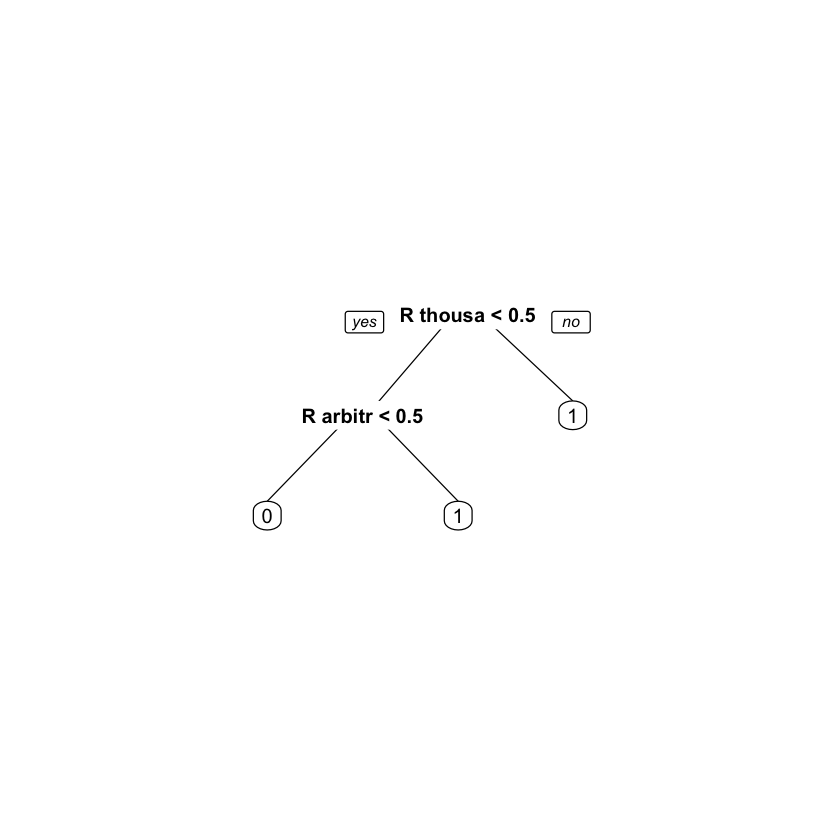

In [62]:
prp(wikiCART)

# Problem-specific Knowledge

We weren't able to improve on the baseline using the raw textual information. More specifically, the words themselves were not useful. There are other options though, and in this section we will try two techniques - identifying a key class of words, and counting words.

The key class of words we will use are website addresses. "Website addresses" (also known as URLs - Uniform Resource Locators) are comprised of two main parts. An example would be "http://www.google.com". The first part is the protocol, which is usually "http" (HyperText Transfer Protocol). The second part is the address of the site, e.g. "www.google.com". We have stripped all punctuation so links to websites appear in the data as one word, e.g. "httpwwwgooglecom". We hypothesize that given that a lot of vandalism seems to be adding links to promotional or irrelevant websites, the presence of a web address is a sign of vandalism.

We can search for the presence of a web address in the words added by searching for "http" in the Added column. The grepl function returns TRUE if a string is found in another string, e.g.

grepl("cat","dogs and cats",fixed=TRUE) # TRUE

grepl("cat","dogs and rats",fixed=TRUE) # FALSE

Create a copy of your dataframe from the previous question:

wikiWords2 = wikiWords

Make a new column in wikiWords2 that is 1 if "http" was in Added:

wikiWords2\$HTTP = ifelse(grepl("http",wiki\$Added,fixed=TRUE), 1, 0)

Based on this new column, how many revisions added a link?

In [63]:
wikiWords2 = wikiWords
wikiWords2$HTTP = ifelse(grepl("http",wiki$Added,fixed=TRUE), 1, 0)

In [66]:
table(wikiWords2$HTTP)


   0    1 
3659  217 

In [67]:
wikiTrain2 = subset(wikiWords2, spl==TRUE)

wikiTest2 = subset(wikiWords2, spl==FALSE)

In [68]:
wikiCART2 = rpart(Vandal ~., data=wikiTrain2, method="class")

In [69]:
pred2 = predict(wikiCART2, newdata = wikiTest2, type='class')

In [70]:
t = table(wikiTest2$Vandal, pred2)
sum(diag(t))/sum(t)

[1] 0.5726569

Another possibility is that the number of words added and removed is predictive, perhaps more so than the actual words themselves. We already have a word count available in the form of the document-term matrices (DTMs).

Sum the rows of dtmAdded and dtmRemoved and add them as new variables in your data frame wikiWords2 (called NumWordsAdded and NumWordsRemoved) by using the following commands:

In [71]:
wikiWords2$NumWordsAdded = rowSums(as.matrix(dtmAdded))
wikiWords2$NumWordsRemoved = rowSums(as.matrix(dtmRemoved))

In [73]:
mean(wikiWords2$NumWordsAdded)

[1] 4.050052

In [74]:
wikiTrain2 = subset(wikiWords2, spl==TRUE)

wikiTest2 = subset(wikiWords2, spl==FALSE)
wikiCART2 = rpart(Vandal ~., data=wikiTrain2, method="class")
pred2 = predict(wikiCART2, newdata = wikiTest2, type='class')
t = table(wikiTest2$Vandal, pred2)
sum(diag(t))/sum(t)

[1] 0.6552021

## Using Non-Textual Data

We have two pieces of "metadata" (data about data) that we haven't yet used. Make a copy of wikiWords2, and call it wikiWords3:

In [75]:
wikiWords3 = wikiWords2

Then add the two original variables Minor and Loggedin to this new data frame:

In [76]:
wikiWords3$Minor = wiki$Minor

wikiWords3$Loggedin = wiki$Loggedin

In [77]:
wikiTrain3 = subset(wikiWords3, spl==TRUE)
wikiTest3 = subset(wikiWords3, spl==FALSE)
wikiCART3 = rpart(Vandal ~., data=wikiTrain3, method="class")
pred3 = predict(wikiCART3, newdata = wikiTest3, type='class')
t = table(wikiTest3$Vandal, pred3)
sum(diag(t))/sum(t)

[1] 0.7188306

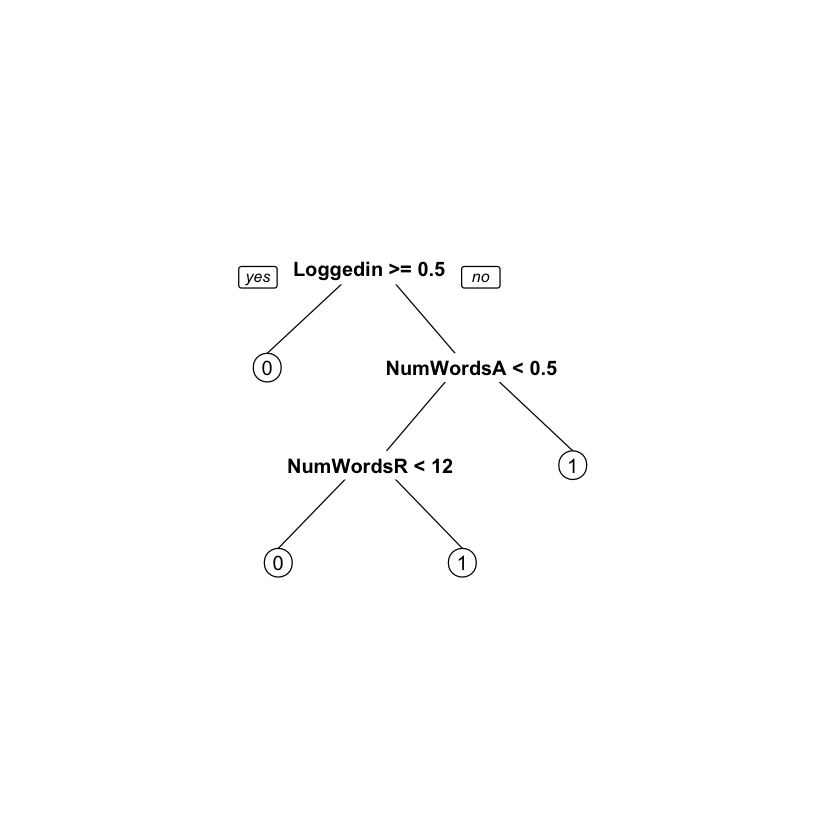

In [78]:
prp(wikiCART3)

# AUTOMATING REVIEWS IN MEDICINE

In [79]:
clinical = read.csv('data/clinical_trial.csv', stringsAsFactors=FALSE)

In [80]:
str(clinical)

'data.frame':	1860 obs. of  3 variables:
 $ title   : chr  "Treatment of Hodgkin's disease and other cancers with 1,3-bis(2-chloroethyl)-1-nitrosourea (BCNU; NSC-409962)." "Cell mediated immune status in malignancy--pretherapy and post-therapy assessment." "Neoadjuvant vinorelbine-capecitabine versus docetaxel-doxorubicin-cyclophosphamide in early nonresponsive breast cancer: phase "| __truncated__ "Randomized phase 3 trial of fluorouracil, epirubicin, and cyclophosphamide alone or followed by Paclitaxel for early breast can"| __truncated__ ...
 $ abstract: chr  "" "Twenty-eight cases of malignancies of different kinds were studied to assess T-cell activity and population before and after in"| __truncated__ "BACKGROUND: Among breast cancer patients, nonresponse to initial neoadjuvant chemotherapy is associated with unfavorable outcom"| __truncated__ "BACKGROUND: Taxanes are among the most active drugs for the treatment of metastatic breast cancer, and, as a consequence, they "| __trunc

** How many characters are there in the longest abstract? (Longest here is defined as the abstract with the largest number of characters.)**

In [83]:
summary(nchar(clinical$abstract))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1195    1583    1480    1820    3708 

**How many search results provided no abstract? (HINT: A search result provided no abstract if the number of characters in the abstract field is zero.)**

In [84]:
sum(nchar(clinical$abstract)==0)

[1] 112

In [85]:
which.min(nchar(clinical$title))

[1] 1258

In [86]:
clinical$title[1258]

[1] "A decade of letrozole: FACE."

## Pre-Processing

In [87]:
corpusTitle = Corpus(VectorSource(clinical$title))
corpusAbstract = Corpus(VectorSource(clinical$abstract))

In [88]:
corpusTitle = tm_map(corpusTitle, tolower)
corpusTitle = tm_map(corpusTitle, PlainTextDocument)
corpusAbstract = tm_map(corpusAbstract, tolower)
corpusAbstract = tm_map(corpusAbstract, PlainTextDocument)

In [89]:
corpusTitle = tm_map(corpusTitle, removePunctuation)
corpusAbstract = tm_map(corpusAbstract, removePunctuation)

In [90]:
corpusTitle = tm_map(corpusTitle, removeWords, stopwords('english'))
corpusAbstract = tm_map(corpusAbstract, removeWords, stopwords('english'))

In [91]:
corpusTitle = tm_map(corpusTitle, stemDocument)
corpusAbstract = tm_map(corpusAbstract, stemDocument)

In [113]:
dtmTitle = DocumentTermMatrix(corpusTitle)
dtmAbstract = DocumentTermMatrix(corpusAbstract)

In [114]:
dtmTitle = removeSparseTerms(dtmTitle, 0.95)
dtmAbstract = removeSparseTerms(dtmAbstract, 0.95)

In [115]:
dtmTitle = as.data.frame(as.matrix(dtmTitle))
dtmAbstract = as.data.frame(as.matrix(dtmAbstract))

In [102]:
str(dtmTitle)

'data.frame':	1860 obs. of  31 variables:
 $ adjuv          : num  0 0 0 0 0 0 0 0 1 0 ...
 $ advanc         : num  0 0 0 0 0 0 1 0 0 0 ...
 $ breast         : num  0 0 1 1 1 1 0 1 1 1 ...
 $ cancer         : num  1 0 1 1 1 1 0 1 1 2 ...
 $ chemotherapi   : num  0 0 0 0 1 1 0 0 0 0 ...
 $ clinic         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ combin         : num  0 0 0 0 1 0 1 0 0 0 ...
 $ compar         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ cyclophosphamid: num  0 0 0 1 0 0 0 0 0 0 ...
 $ docetaxel      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ doxorubicin    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ earli          : num  0 0 1 1 0 0 0 1 0 0 ...
 $ effect         : num  0 0 0 0 1 0 0 1 0 1 ...
 $ group          : num  0 0 0 0 0 0 0 0 1 1 ...
 $ iii            : num  0 0 1 0 0 0 0 0 0 1 ...
 $ metastat       : num  0 0 0 0 1 0 0 0 0 0 ...
 $ patient        : num  0 0 0 0 1 0 1 0 1 1 ...
 $ phase          : num  0 0 1 1 0 0 0 0 0 1 ...
 $ plus           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ postmenopaus   : num  0 

In [101]:
str(dtmAbstract)

'data.frame':	1860 obs. of  335 variables:
 $ 0001           : num  0 0 0 0 0 7 0 0 0 0 ...
 $ 001            : num  0 0 0 1 0 0 0 1 0 0 ...
 $ 005            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 100            : num  0 1 0 0 0 0 0 0 0 0 ...
 $ 500            : num  0 0 1 0 2 0 0 0 0 0 ...
 $ 5fluorouracil  : num  0 0 0 0 0 1 0 0 0 0 ...
 $ accord         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ achiev         : num  0 0 0 0 0 0 1 0 1 0 ...
 $ activ          : num  0 2 0 1 0 0 1 0 0 0 ...
 $ addit          : num  0 0 2 0 0 0 0 0 0 0 ...
 $ adjuv          : num  0 0 0 2 0 1 0 2 4 0 ...
 $ administ       : num  0 0 0 0 0 0 1 0 0 0 ...
 $ administr      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ advanc         : num  0 0 0 0 0 0 1 0 0 0 ...
 $ advers         : num  0 0 0 0 0 0 0 0 0 4 ...
 $ age            : num  0 0 0 1 0 0 0 0 0 0 ...
 $ agent          : num  0 0 0 0 1 0 1 0 0 0 ...
 $ aim            : num  0 0 0 0 0 1 0 0 0 0 ...
 $ alon           : num  0 0 0 0 0 0 0 0 3 0 ...
 $ also           : num  0

In [104]:
x = colSums(dtmAbstract)

In [105]:
which.max(x)

patient 
    212

In [106]:
x[212]

patient 
   8381

In [116]:
colnames(dtmTitle) = paste0("T", colnames(dtmTitle))

colnames(dtmAbstract) = paste0("A", colnames(dtmAbstract))

In [117]:
dtm = cbind(dtmTitle, dtmAbstract)

Warning message:
In data.row.names(row.names, rowsi, i): some row.names duplicated: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,25

In [132]:
dtm$trial = clinical$trial

In [133]:
str(dtm)

'data.frame':	1860 obs. of  367 variables:
 $ Tadjuv          : num  0 0 0 0 0 0 0 0 1 0 ...
 $ Tadvanc         : num  0 0 0 0 0 0 1 0 0 0 ...
 $ Tbreast         : num  0 0 1 1 1 1 0 1 1 1 ...
 $ Tcancer         : num  1 0 1 1 1 1 0 1 1 2 ...
 $ Tchemotherapi   : num  0 0 0 0 1 1 0 0 0 0 ...
 $ Tclinic         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Tcombin         : num  0 0 0 0 1 0 1 0 0 0 ...
 $ Tcompar         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Tcyclophosphamid: num  0 0 0 1 0 0 0 0 0 0 ...
 $ Tdocetaxel      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Tdoxorubicin    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Tearli          : num  0 0 1 1 0 0 0 1 0 0 ...
 $ Teffect         : num  0 0 0 0 1 0 0 1 0 1 ...
 $ Tgroup          : num  0 0 0 0 0 0 0 0 1 1 ...
 $ Tiii            : num  0 0 1 0 0 0 0 0 0 1 ...
 $ Tmetastat       : num  0 0 0 0 1 0 0 0 0 0 ...
 $ Tpatient        : num  0 0 0 0 1 0 1 0 1 1 ...
 $ Tphase          : num  0 0 1 1 0 0 0 0 0 1 ...
 $ Tplus           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Tpos

In [134]:
set.seed(144)
spl = sample.split(dtm$trial, SplitRatio = 0.7)
train = subset(dtm, spl == TRUE)
test = subset(dtm, spl == FALSE)

In [135]:
# Acc test:
table(test$trial)


  0   1 
313 245 

In [136]:
313/(313+245)

[1] 0.5609319

In [158]:
dtmCART = rpart(trial ~., data=train, method="class")
pred = predict(dtmCART, newdata = test, type='class')
t = table(test$trial, pred)
sum(diag(t))/sum(t)

[1] 0.7580645

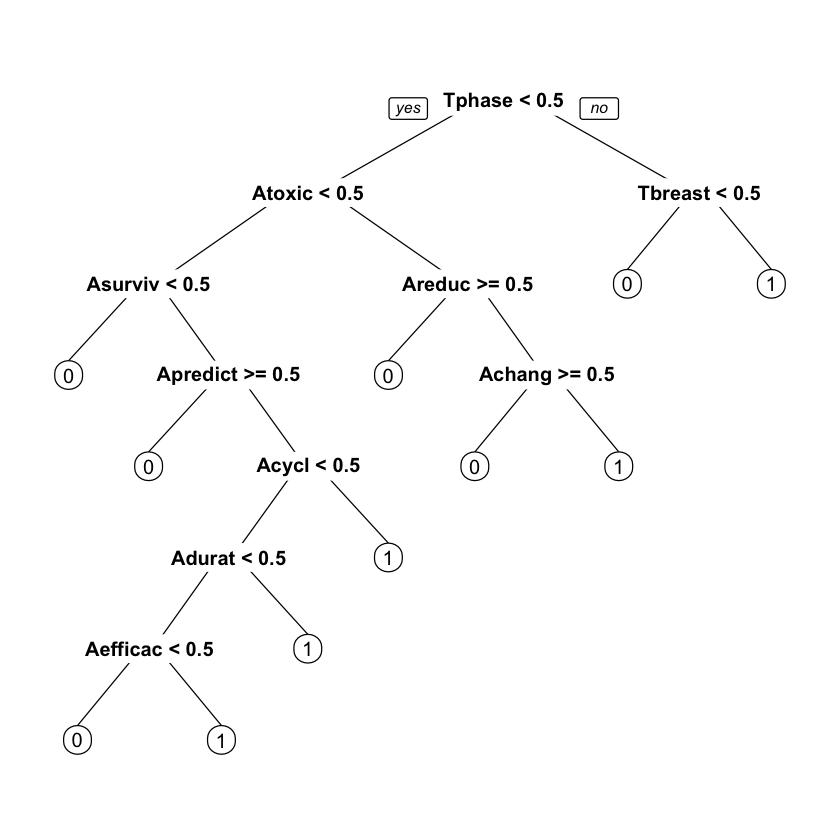

In [138]:
prp(dtmCART)

In [151]:
predT = predict(dtmCART, newdata = train)

summary(predT[,2])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05455 0.13640 0.28750 0.43930 0.78230 0.87190 

In [152]:
table(train$trial, predT[,2] > 0.5)

   
    FALSE TRUE
  0   631   99
  1   131  441

In [154]:
t = table(train$trial, predT[,2] > 0.5)
sum(diag(t))/sum(t)

[1] 0.8233487

In [155]:
# sensitivity or true positive rate (TPR)
# TP/(TP+FN)
441/(441+131)

[1] 0.770979

In [156]:
# specificity (SPC) or true negative rate
# TN/(TN+FP)
631/(631+99)

[1] 0.8643836

In [160]:
library(ROCR)
pred = predict(dtmCART, newdata = test)
predROCR = prediction(pred[,2], test$trial)

[[1]]
[1] 0.8371063

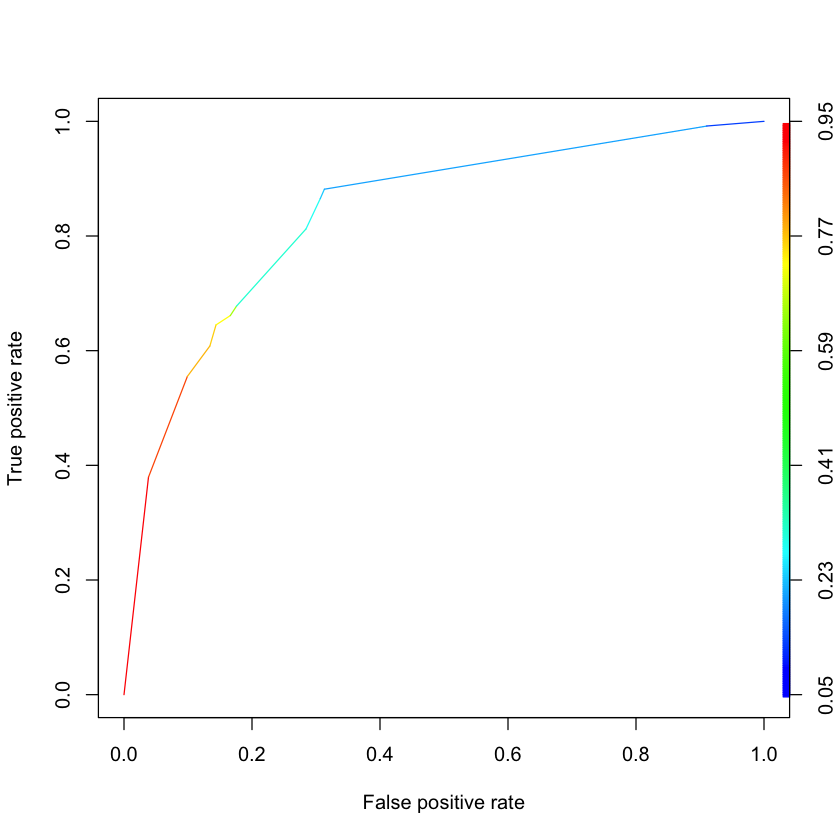

In [162]:
perfROCR = performance(predROCR, "tpr", "fpr")
plot(perfROCR, colorize=TRUE)
performance(predROCR, "auc")@y.values

## DECISION-MAKER TRADEOFFS

The decision maker for this problem, a researcher performing a review of the medical literature, would use a model (like the CART one we built here) in the following workflow:

1) For all of the papers retreived in the PubMed Search, predict which papers are clinical trials using the model. This yields some initial Set A of papers predicted to be trials, and some Set B of papers predicted not to be trials. (See the figure below.)

2) Then, the decision maker manually reviews all papers in Set A, verifying that each paper meets the study's detailed inclusion criteria (for the purposes of this analysis, we assume this manual review is 100% accurate at identifying whether a paper in Set A is relevant to the study). This yields a more limited set of papers to be included in the study, which would ideally be all papers in the medical literature meeting the detailed inclusion criteria for the study.

3) Perform the study-specific analysis, using data extracted from the limited set of papers identified in step 2.

**A paper that should have been included in Set A will be missed, affecting the quality of the results of Step 3. A paper that should have been included in Set A will be missed, affecting the quality of the results of Step 3. - correct**

**
A paper will be mistakenly added to Set A, yielding additional work in Step 2 of the process but not affecting the quality of the results of Step 3. **

**
A false negative is more costly than a false positive; the decision maker should use a probability threshold less than 0.5 for the machine learning model.**

A false negative might negatively affect the results of the literature review and analysis, while a false positive is a nuisance (one additional paper that needs to be manually checked). As a result, the cost of a false negative is much higher than the cost of a false positive, so much so that many studies actually use no machine learning (aka no Step 1) and have two people manually review each search result in Step 2. As always, we prefer a lower threshold in cases where false negatives are more costly than false positives, since we will make fewer negative predictions.